# Post Hashrate Ergo Propter Hashrate?
## Discovering the influence that Bitcoin hashrate has on its price.
___
As an increasing number of people try to model the price of Bitcoin, the system's hashrate often becomes a topic of discussion. Being a de jure predictor of price, the Bitcoin hashrate is believed to be a cause of changes in price. A historical inacurracy regarding this claim is that hashrate influences price because the price and hashrate are linearly correlated. Many of us have learned in secondary school statistics classes that correlation does *not* mean causation, though, so we can't conclude that hashrate actually *causes* price simply due to the two metrics' correlation. To do this, we need to prove causation. In this notebook, we'll discover whether the price and hashrate of Bitcoin are actually correlated and determine whether hashrate causes price.

We'll conduct this experiment by first determining whether the price and hashrate are linearly correlated by calculating the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) of the two datasets. Then, we'll determine whether the price at timestep *t* is [Granger caused](https://en.wikipedia.org/wiki/Granger_causality) by the hashrate at timestep *t - n*, where *n* is the number of timesteps (in our case, days) between the price and the hashrate that causes said price.

Let's start off by setting up our notebook and importing all of the libraries we'll be using throughout our experiment.
```bash
curl https://api.blockchain.info/charts/hash-rate\?timespan\=all\&format\=json -o btc-hashrate.json
curl https://api.blockchain.info/charts/market-price\?timespan\=all\&format\=json -o btc-price.json
```

In [1]:
%matplotlib inline
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.statespace.tools import diff

Now that we've import our libraries, we can initialize our constants. Change the price and hashrate filepaths according to your machine. Leave the rest as they are for now, as they'll be important later.

In [2]:
VERBOSE_TEST = False
NUM_LAGS = 15
STATSIG_LEVEL = 0.05
PRICE_FILEPATH = '/Users/aunyks/dev/price-hashrate/btc-price.json'
HASHRATE_FILEPATH = '/Users/aunyks/dev/price-hashrate/btc-hashrate.json'

Now let's actually open our dataset files and load their data into some dictionaries, since they're JSON files.

In [3]:
price_dict = {}
hashrate_dict = {}
with open(PRICE_FILEPATH, 'r') as f:
  price_dict = json.load(f)
with open(HASHRATE_FILEPATH, 'r') as f:
  hashrate_dict = json.load(f)

Now that we've loaded our JSON data in to memory, we need to reshape the data for easier processing later.

In [4]:
# [{ 'x': 1000000000, 'y': 200000000 }] => [200000000, ...]
prices = [point['y'] for point in list(price_dict['values'])]
hashrates = [point['y'] for point in list(hashrate_dict['values'])]

The variables `prices` and `hashrates` are lists (1d arrays) that contain our data, and each index maps to a timestep.

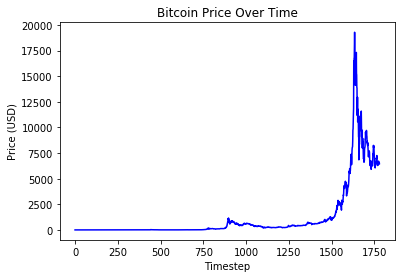

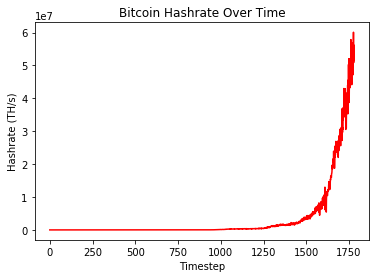

In [5]:
plt.title('Bitcoin Price Over Time')
plt.ylabel('Price (USD)')
plt.xlabel('Timestep')
plt.plot(prices, 'b-')
plt.show()
plt.title('Bitcoin Hashrate Over Time')
plt.ylabel('Hashrate (TH/s)')
plt.xlabel('Timestep')
plt.plot(hashrates, 'r-')
plt.show()

Let's determine the correlation between the price and hashrate over time. If the two are posititvely correlated, then the two increase at similar times. If the two are negatively correlated, then one increases while the other decreases. If the two are not correlated (which I believe is highly unlikely), then there's no linear relationship between the two.

In [6]:
# pearsonr gives us the correlation coefficient and
# the p value of the data
correlation, corr_p = pearsonr(prices, hashrates)
print('Assuming the two are independent of each other, we can say with {0}% confidence that the Bitcoin price and hashrate are {1} correlated with a factor of ~{2}.'.format('%.2f' % ((1 - corr_p) * 100), 'positively' if correlation > 0 else 'negatively', '%.2f' % correlation))

Assuming the two are independent of each other, we can say with 100.00% confidence that the Bitcoin price and hashrate are positively correlated with a factor of ~0.75.


In [7]:
print('First 5 Prices and Hashrates')
print('-' * 28)
print('Price (USD)\tHashrate (TH/s)')
for i in range(5):
  print(str(prices[i]) + '\t\t' + str(hashrates[i]))

First 5 Prices and Hashrates
----------------------------
Price (USD)	Hashrate (TH/s)
0.0		4.971026962962963e-08
0.0		0.0
0.0		0.0
0.0		6.959437748148148e-07
0.0		5.269288580740741e-06


We've seen empirically that price and hashrate are linearly correlated, now let's see if hashrate Granger causes price. To do this, we need our data to be [stationary](https://en.wikipedia.org/wiki/Stationary_process). We'll use the [Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test) to determine whether a dataset is stationary.  

It's important to recognize that the stationary datasets are different from their plain counterparts: the price dataset shows the daily change in price over time, while the stationary price shows the daily change in returns over time. The hashrate dataset shows the daily change in hashrate over time, while the stationary hashrate dataset shows how quickly a change in hashrate occurs.

In [8]:
def is_stationary(X):
  result = adfuller(X)
  return result[0] < 0 and result[1] <= STATSIG_LEVEL

And these two datasets have a trending increase over time, so we need to [difference](https://people.duke.edu/~rnau/411diff.htm) the datasets until they're stationary.

In [9]:
def diff_til_stationary(X):
  this_data = X
  num_diffs = 0
  while not is_stationary(this_data):
    num_diffs += 1
    this_data = diff(X)
  return (this_data, num_diffs)

In [10]:
price_diff_results = diff_til_stationary(prices)
hashrate_diff_results = diff_til_stationary(hashrates)
stationary_prices = price_diff_results[0]
stationary_hashrates = hashrate_diff_results[0]
print('Diff\'d prices {0} times'.format(price_diff_results[1]))
print('Diff\'d hashrates {0} times'.format(hashrate_diff_results[1]))

Diff'd prices 1 times
Diff'd hashrates 1 times


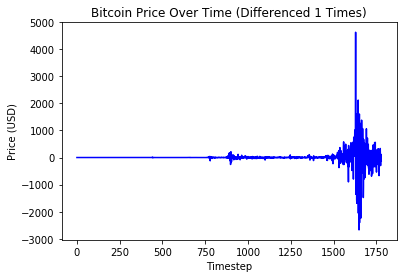

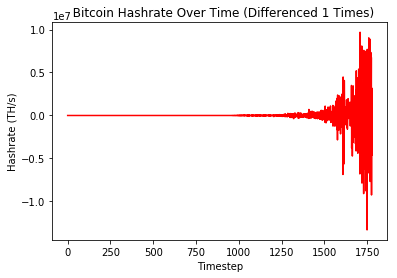

In [11]:
plt.title('Bitcoin Price Over Time (Differenced {0} Times)'.format(price_diff_results[1]))
plt.ylabel('Price (USD)')
plt.xlabel('Timestep')
plt.plot(stationary_prices, 'b-')
plt.show()
plt.title('  Bitcoin Hashrate Over Time (Differenced {0} Times)'.format(hashrate_diff_results[1]))
plt.ylabel('Hashrate (TH/s)')
plt.xlabel('Timestep')
plt.plot(stationary_hashrates, 'r-')
plt.show()

We have our stationary data now, so let's start off the analysis of them by checking the correlation between them.

In [12]:
# pearsonr gives us the correlation coefficient and
# the p value of the data
stationary_correlation, stationary_corr_p = pearsonr(stationary_prices, stationary_hashrates)
print('Assuming the two are independent of each other, we can say with {0}% confidence that Bitcoin\'s daily returns and daily change in hashrate are {1} correlated with a factor of approximately {2}.'.format('%.2f' % ((1 - stationary_corr_p) * 100), 'positively' if stationary_correlation > 0 else 'negatively', '%.2f' % stationary_correlation))

Assuming the two are independent of each other, we can say with 53.01% confidence that Bitcoin's daily returns and daily change in hashrate are negatively correlated with a factor of approximately -0.02.


This is a very interesting insight. While price and the hashrate have strong positive correlation, the daily returns and daily change in hashrate are negatively correlated, albeit loosely.  

This *could* mean that a Bitcoin investor's daily returns increase when the change in hashrate decreases, but we won't assert this idea, as our correlation test had about 50% confidence (p-value ≈ 0.5), which is less than the minimum confidence level we need for statistical significance (95% confidence, p-value <= 0.05).

We've seen the correlations among the datasets, now let's test the causality of hashrate on price.

In [13]:
hashrate_cause_price_result = grangercausalitytests(np.column_stack((stationary_prices, stationary_hashrates)), NUM_LAGS, verbose=VERBOSE_TEST)

This gives us the results of performing our tests on our data. The results look like this:

In [14]:
for lag in range(1, NUM_LAGS + 1):
  num_times_diffed = hashrate_diff_results[1]
  # Because differencing shortens the length of the data,
  # the number of days in the past of each lag is proportional
  # to the ratio between the length of the data before and after differencing
  days_behind = lag * int(len(prices) / len(stationary_prices))
  print('Days Behind: approx. {0} Lag: {1}'.format(days_behind, lag))
  print('-' * 40)
  print('Test\t\tResult')
  for test, results in (list(hashrate_cause_price_result.values())[lag - 1][0]).items():
    print('{0}\t{1}'.format(test, results))
  print('-' * 40)

Days Behind: approx. 1 Lag: 1
----------------------------------------
Test		Result
ssr_ftest	(2.6808374415934484, 0.10173946339782156, 1776.0, 1)
ssr_chi2test	(2.685365883217761, 0.10127396165314134, 1)
lrtest	(2.6833411666993925, 0.10140277311668117, 1)
params_ftest	(2.6808374415930976, 0.10173946339784311, 1776.0, 1.0)
----------------------------------------
Days Behind: approx. 2 Lag: 2
----------------------------------------
Test		Result
ssr_ftest	(2.470973402748302, 0.08479352697134841, 1773.0, 2)
ssr_chi2test	(4.955883485715151, 0.0839157681920064, 2)
lrtest	(4.948989437099954, 0.08420552700067456, 2)
params_ftest	(2.470973402749839, 0.08479352697123499, 1773.0, 2.0)
----------------------------------------
Days Behind: approx. 3 Lag: 3
----------------------------------------
Test		Result
ssr_ftest	(2.126473696243258, 0.0949432205325677, 1770.0, 3)
ssr_chi2test	(6.404650437668253, 0.09349966185672265, 3)
lrtest	(6.3931362982984865, 0.09397356800375699, 3)
params_ftest	(2.1264

But that's alot to take in at once, so let's only show the p values of our tests.

In [15]:
for lag in range(1, NUM_LAGS + 1):
  num_times_diffed = hashrate_diff_results[1]
  days_behind = lag * int(len(prices) / len(stationary_prices))
  print('Days Behind: approx. {0} Lag: {1}'.format(days_behind, lag))
  print('-' * 40)
  print('Test\t\tp-values')
  for test, results in (list(hashrate_cause_price_result.values())[lag - 1][0]).items():
    p_value = results[1]
    print('{0}\t{1}'.format(test, p_value))
  print('-' * 40)

Days Behind: approx. 1 Lag: 1
----------------------------------------
Test		p-values
ssr_ftest	0.10173946339782156
ssr_chi2test	0.10127396165314134
lrtest	0.10140277311668117
params_ftest	0.10173946339784311
----------------------------------------
Days Behind: approx. 2 Lag: 2
----------------------------------------
Test		p-values
ssr_ftest	0.08479352697134841
ssr_chi2test	0.0839157681920064
lrtest	0.08420552700067456
params_ftest	0.08479352697123499
----------------------------------------
Days Behind: approx. 3 Lag: 3
----------------------------------------
Test		p-values
ssr_ftest	0.0949432205325677
ssr_chi2test	0.09349966185672265
lrtest	0.09397356800375699
params_ftest	0.09494322053211617
----------------------------------------
Days Behind: approx. 4 Lag: 4
----------------------------------------
Test		p-values
ssr_ftest	0.07239290423526101
ssr_chi2test	0.0706571521731785
lrtest	0.07126106331995186
params_ftest	0.07239290423508253
----------------------------------------
Day

Actually, let's just see the average p value among every test at each lag.

In [16]:
for lag in range(1, NUM_LAGS + 1):
  num_times_diffed = hashrate_diff_results[1]
  days_behind = lag * int(len(prices) / len(stationary_prices))
  print('Days Behind: approx. {0} Lag: {1}'.format(days_behind, lag))
  print('-' * 40)
  print('Average p-value')
  test_ps = []
  for test, results in (list(hashrate_cause_price_result.values())[lag - 1][0]).items():
    p_value = results[1]
    test_ps.append(p_value)
  average_p = np.mean(test_ps)
  print(average_p)
  print('-' * 40)

Days Behind: approx. 1 Lag: 1
----------------------------------------
Average p-value
0.1015389153913718
----------------------------------------
Days Behind: approx. 2 Lag: 2
----------------------------------------
Average p-value
0.0844270872838161
----------------------------------------
Days Behind: approx. 3 Lag: 3
----------------------------------------
Average p-value
0.09433991773129088
----------------------------------------
Days Behind: approx. 4 Lag: 4
----------------------------------------
Average p-value
0.07167600599086847
----------------------------------------
Days Behind: approx. 5 Lag: 5
----------------------------------------
Average p-value
0.01860919883177018
----------------------------------------
Days Behind: approx. 6 Lag: 6
----------------------------------------
Average p-value
0.002129436849101371
----------------------------------------
Days Behind: approx. 7 Lag: 7
----------------------------------------
Average p-value
0.0037742388533045356
----

Awesome, so what we're looking at is how far back in time the hashrate (and price) influences the current price. Higher p values indicate lower statistical significance, or how much we can trust the test. We can see that the further back we look, the more the hashrate influences the price. This is could be useful for mid and long term prce forecasting, but it's not very useful for the short term.  

Let's see how quickly the hashrate causes price. We do this by finding lag and with an average p value that meets our statistical significance.

In [17]:
earliest_lag = -1
earliest_sig_days_past = -1
earliest_sig_p_value = -1
for lag in list(hashrate_cause_price_result.keys()):
  num_times_diffed = hashrate_diff_results[1]
  days_behind = lag * int(len(prices) / len(stationary_prices))
  test_ps = []
  for test, results in (list(hashrate_cause_price_result.values())[lag - 1][0]).items():
    p_value = results[1]
    test_ps.append(p_value)
  average_p = np.mean(test_ps)
  if average_p <= STATSIG_LEVEL and earliest_sig_days_past == -1:
    earliest_sig_days_past = days_behind
    earliest_lag = lag
    earliest_sig_p_value = average_p

In [18]:
print('We can say with {0}% confidence that Bitcoin\'s daily return at any time (t) is caused by a change in hashrate no earlier than {1} days prior to t.'.format('%.2f' % ((1 - earliest_sig_p_value) * 100), earliest_sig_days_past))

We can say with 98.14% confidence that Bitcoin's daily return at any time (t) is caused by a change in hashrate no earlier than 5 days prior to t.


There we are. Now we know that Bitcoin's price and hashrate are linearly correlated, that the change in hashrate has a degree of causality of the daily returns, and that the change in hashrate as early as 5 days before the day of a return has an influence on that return. Or, a return at timestep *t* is Granger caused by a change in hashrate at timestep *t - 5*.